In [1]:
!pip install segmentation_models_pytorch

DEPRECATION: Loading egg at /users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/CLEAN-0.1-py3.13.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
!git clone https://github.com/yjn870/DnCNN-pytorch.git

fatal: destination path 'DnCNN-pytorch' already exists and is not an empty directory.


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset,random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import glob
import os
import numpy as np
from matplotlib import image as mpimg

/users/kolodny/gyanai/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset class

In [4]:
import os

data_path = '/users/kolodny/gyanai/LF-MRI-Denoising/Data'
png_folder = os.path.join(data_path, 'Images')

checkpoints_path = '/users/kolodny/gyanai/LF-MRI-Denoising/checkpoints'
os.makedirs(checkpoints_path, exist_ok=True)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image

class HighFrequencyDataset(Dataset):
    def __init__(self, images_path):
        self.images_path = images_path
        self.images = self.read_images()

    def read_images(self) -> torch.Tensor:
        image_file_paths = [f for f in os.listdir(self.images_path) if f.lower().endswith('.png')]
        images = [Image.open(os.path.join(self.images_path, img_path)) for img_path in image_file_paths]
        return self.transform_images(images)

    def transform_images(self, images: list[Image]) -> torch.Tensor:
        transform = T.Compose([
            T.Resize((256, 256)),
            T.ToTensor(),
        ])
        return torch.stack([transform(image) for image in images])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx) -> torch.Tensor:
        return self.images[idx]


In [6]:
dataset = HighFrequencyDataset(png_folder)

In [7]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=0)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [8]:
import random
import torch

def set_seed(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [9]:
set_seed()

In [10]:
def add_gaussian_noise(x: torch.Tensor, max_sigma: float, min_sigma: float = 0):
    sigmas = torch.rand(x.size(0), 1, 1, 1, device=x.device) * (max_sigma - min_sigma) + min_sigma
    noise = torch.randn_like(x) * sigmas
    return x + noise, sigmas

# DNCNN-B

In [ ]:
import torch
import sys
from DnCNN import DnCNN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DnCNN(channels=1, num_of_layers=20)  # 20-layer blind Gaussian
model = model.to(device)

In [ ]:
import torch
import torch.nn as nn

LERANING_RATE = 1e-4

opt = torch.optim.Adam(model.parameters(), lr=LERANING_RATE)
mse_loss = nn.MSELoss()

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F

NOISE_STD = 0.08
EPOCHS = 5
MODEL_OUT_DIR = os.path.join(checkpoints_path, 'vanilla')

os.makedirs(MODEL_OUT_DIR, exist_ok=True)


best_val = float("inf")

for epoch in range(1, EPOCHS + 1):
    model.train()
    pbar = tqdm(iter(train_loader), desc=f"Epoch {epoch}/{EPOCHS}")
    
    train_loss = 0.0

    for x in pbar:
        x = x.to(device)
        x_noisy, _ = add_gaussian_noise(x, NOISE_STD)
        pred_noise = model(x_noisy)          # predict clean image directly
        pred = x_noisy - pred_noise
        loss = mse_loss(pred, x)     # MSE loss
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.item()

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    train_loss /= len(train_loader)
    tqdm.write(f"Epoch {epoch} | train {train_loss:.8f}")

    # validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xv in iter(val_loader):
            xv = xv.to(device)
            xv_noisy, _ = add_gaussian_noise(xv, NOISE_STD)
            pred_noise = model(xv_noisy)
            pred = xv_noisy - pred_noise
            val_loss += mse_loss(pred, xv).item()
    val_loss /= len(val_loader)

    # track best
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), os.path.join(MODEL_OUT_DIR, "best_model.pt"))

    tqdm.write(f"Epoch {epoch} | val {val_loss:.8f} | best {best_val:.8f}")

Epoch 1/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:54<00:00,  5.53it/s, loss=0.0003]


Epoch 1 | train 0.00179150
Epoch 1 | val 0.00042954 | best 0.00042954


Epoch 2/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0004]


Epoch 2 | train 0.00040442
Epoch 2 | val 0.00037421 | best 0.00037421


Epoch 3/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0004]


Epoch 3 | train 0.00035811
Epoch 3 | val 0.00034283 | best 0.00034283


Epoch 4/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0004]


Epoch 4 | train 0.00033411
Epoch 4 | val 0.00030062 | best 0.00030062


Epoch 5/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0004]


Epoch 5 | train 0.00030726
Epoch 5 | val 0.00063763 | best 0.00030062


Epoch 6/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0022]


Epoch 6 | train 0.00164527
Epoch 6 | val 0.00213739 | best 0.00030062


Epoch 7/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0019]


Epoch 7 | train 0.00214392
Epoch 7 | val 0.00221009 | best 0.00030062


Epoch 8/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0023]


Epoch 8 | train 0.00194469
Epoch 8 | val 0.00214850 | best 0.00030062


Epoch 9/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0038]


Epoch 9 | train 0.00213577
Epoch 9 | val 0.00211958 | best 0.00030062


Epoch 10/10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1626/1626 [04:52<00:00,  5.55it/s, loss=0.0003]


Epoch 10 | train 0.00149747
Epoch 10 | val 0.00042498 | best 0.00030062


In [17]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def compute_psnr(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return psnr(clean_image, denoised_image, data_range=1.0)

def compute_ssim(clean_image: torch.Tensor, denoised_image: torch.Tensor):
    clean_image = clean_image.cpu().numpy()
    denoised_image = denoised_image.cpu().numpy()

    return ssim(clean_image, denoised_image, data_range=1.0)

In [15]:
import matplotlib.pyplot as plt

_ = model.eval()

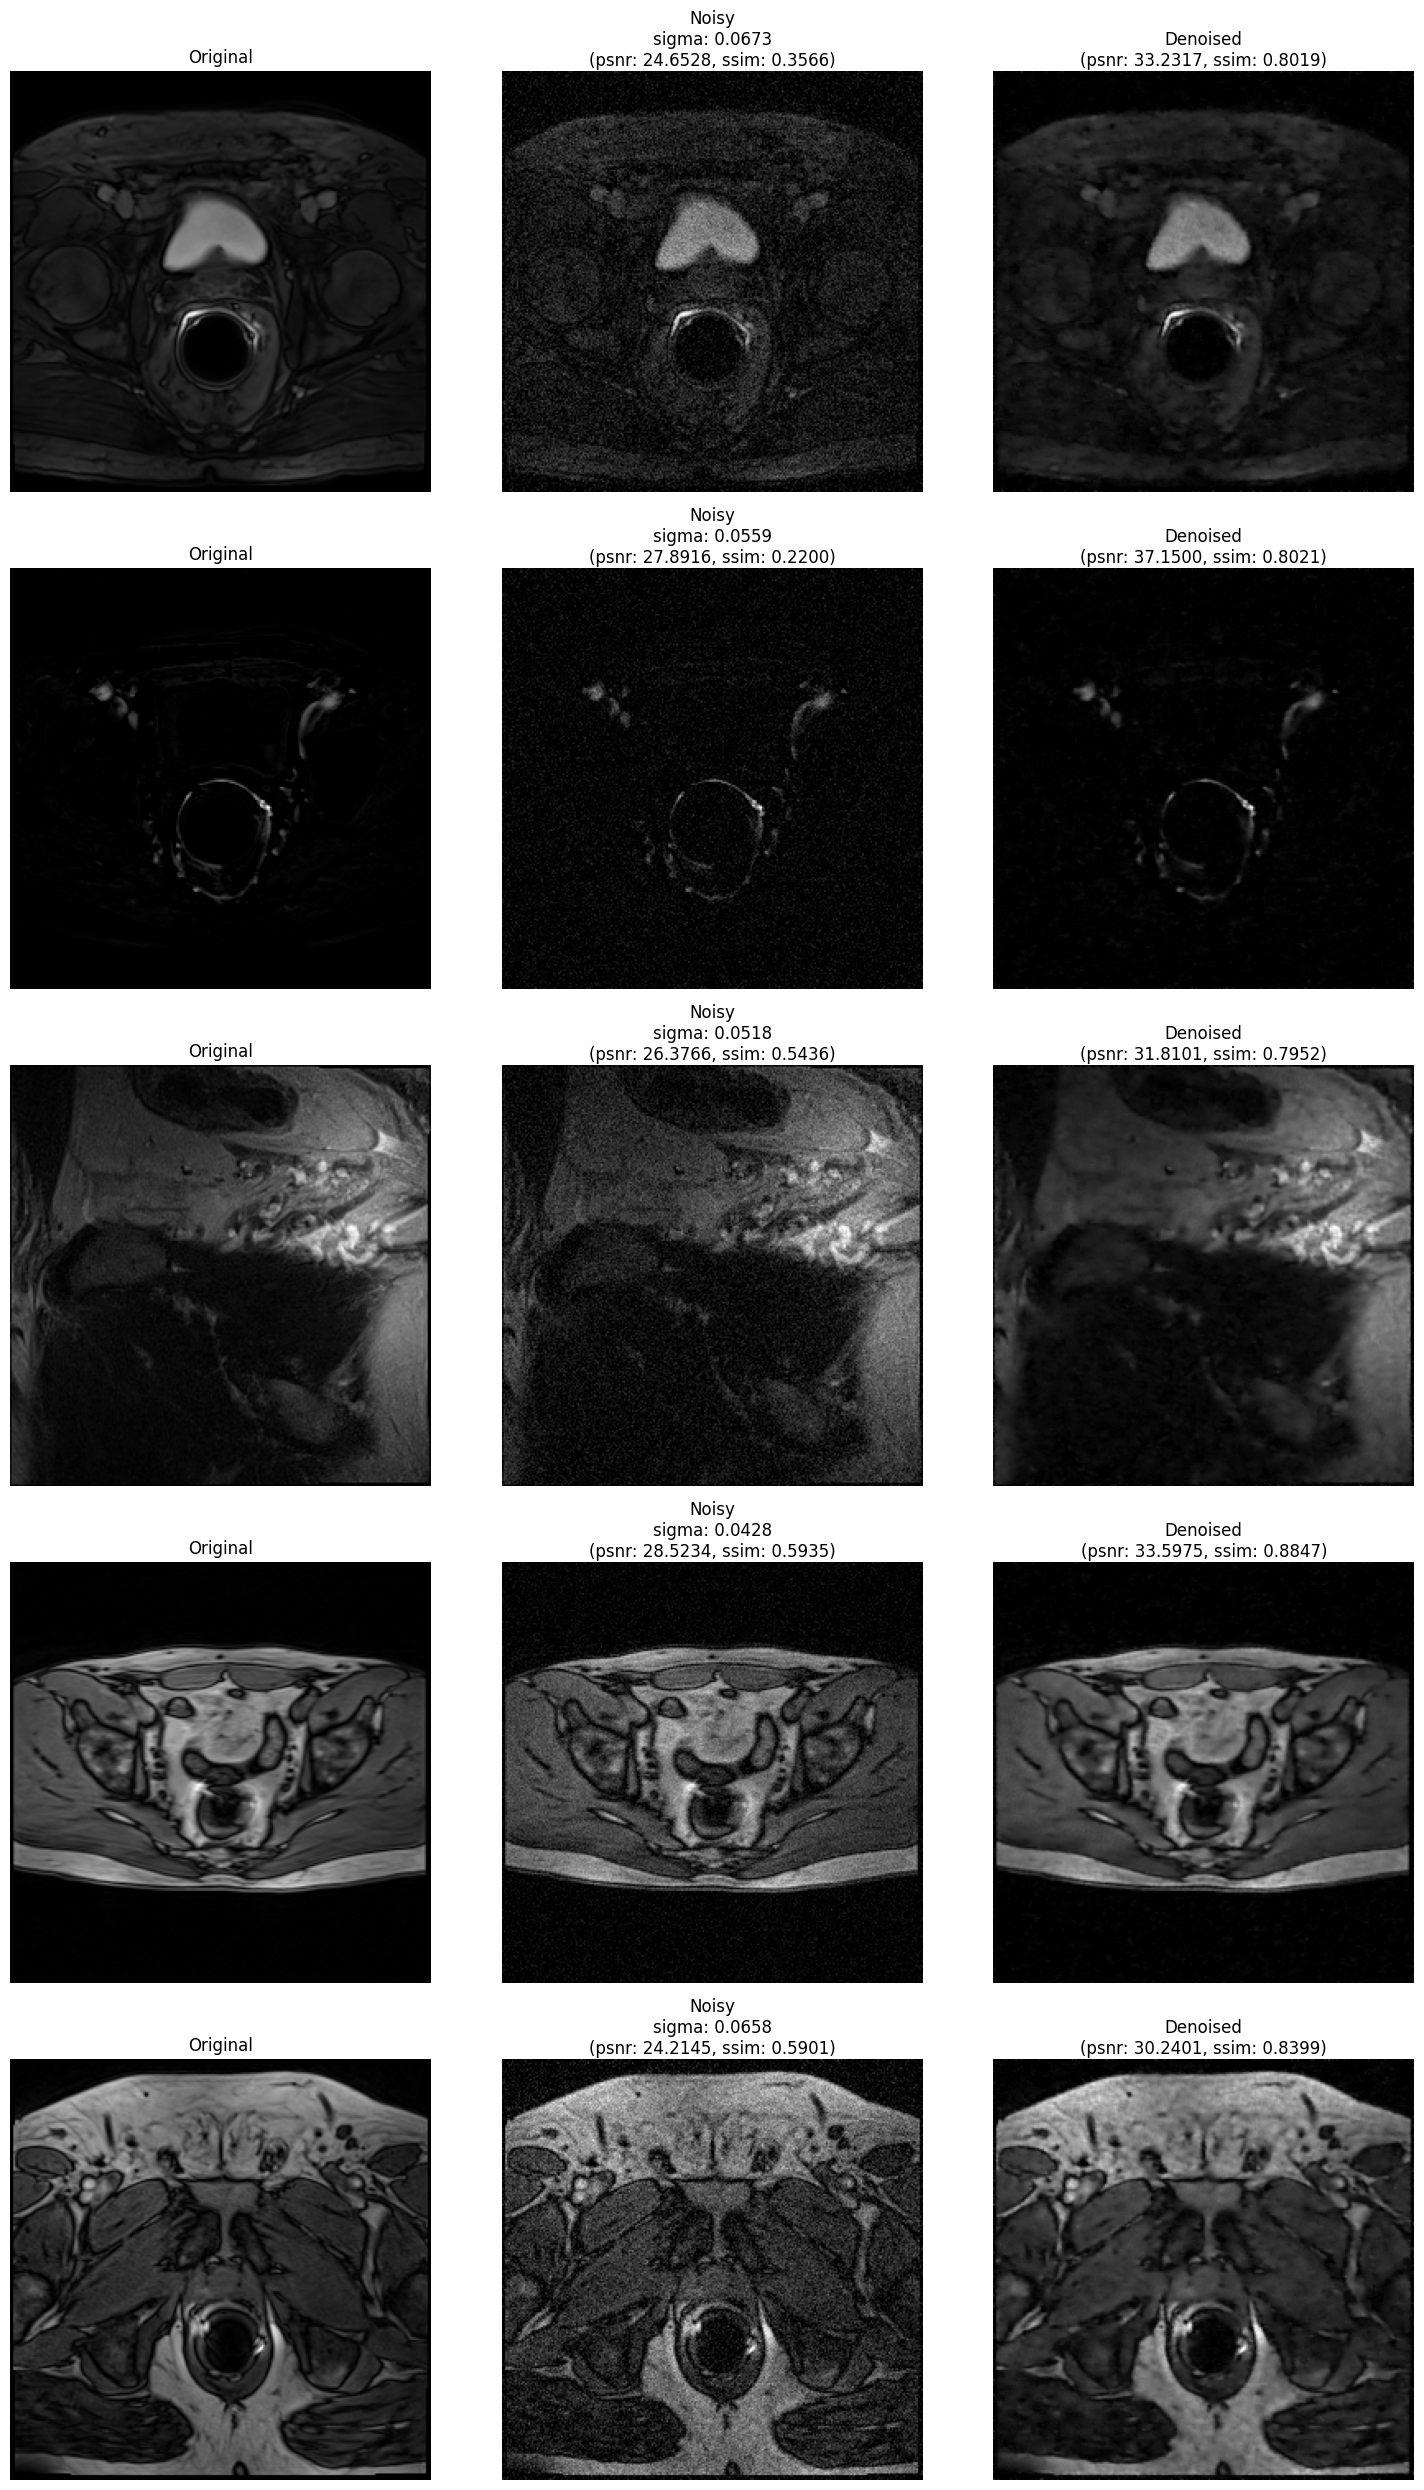

In [22]:
vd = torch.concat(val_dataset).unsqueeze(1)

random_indices = torch.randint(
    0, len(vd), (5,)
)  # just to make sure the model is loaded correctly
plt.figure(figsize=(15, 25))

with torch.no_grad():
    for i, xv in enumerate(vd[random_indices]):
        xv = xv.to(device).unsqueeze(0)
        xv_noisy, sigma = add_gaussian_noise(xv, 0.08, 0.03)
        pred_noise = model(xv_noisy)
        pred = (xv_noisy - pred_noise).clamp(0, 1)
        clamped_noisy = xv_noisy.clamp(0, 1)

        plt.subplot(5, 3, i * 3 + 1)
        plt.imshow(xv.cpu().numpy().squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        plt.subplot(5, 3, i * 3 + 2)
        plt.imshow(clamped_noisy.cpu().numpy().squeeze(), cmap="gray")
        plt.title(
            f"Noisy\nsigma: {sigma.item():.4f}\n(psnr: {compute_psnr(xv.squeeze(), clamped_noisy.squeeze()):.4f}, ssim: {compute_ssim(xv.squeeze(), clamped_noisy.squeeze()):.4f})",
            wrap=True,
        )
        plt.axis("off")

        plt.subplot(5, 3, i * 3 + 3)
        plt.imshow(pred.cpu().numpy().squeeze(), cmap="gray")
        plt.title(
            f"Denoised\n(psnr: {compute_psnr(xv.squeeze(), pred.squeeze()):.4f}, ssim: {compute_ssim(xv.squeeze(), pred.squeeze()):.4f})",
            wrap=True,
        )
        plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
noised_loss = []
noised_psnr = []
noised_ssim = []

validation_loss = []
validation_psnr = []
validation_ssim = []

for xv in tqdm(vd):
    with torch.no_grad():
        # Add noise in k-space
        xv_noisy, _ = add_gaussian_noise(xv, max_sigma=0.08, min_sigma=0.03)
        clamped_noisy = xv_noisy.clamp(0, 1)

        # Denoise
        pred_noise = model(xv_noisy)
        pred = (xv_noisy - pred_noise).clamp(0, 1)
        
    noised_loss.append(mse_loss(xv, clamped_noisy).item())
    noised_psnr.append(compute_psnr(xv.squeeze(), clamped_noisy.squeeze()))
    noised_ssim.append(compute_ssim(xv.squeeze(), clamped_noisy.squeeze()))

    validation_loss.append(mse_loss(xv, pred).item())
    validation_psnr.append(compute_psnr(xv.squeeze(), pred.squeeze()))
    validation_ssim.append(compute_ssim(xv.squeeze(), pred.squeeze()))

print(f"Noised Loss: {sum(noised_loss)/len(noised_loss)}")
print(f"Noised PSNR: {sum(noised_psnr)/len(noised_psnr)}")
print(f"Noised SSIM: {sum(noised_ssim)/len(noised_ssim)}")

print(f"Validation Loss: {sum(validation_loss)/len(validation_loss)}")
print(f"Validation PSNR: {sum(validation_psnr)/len(validation_psnr)}")
print(f"Validation SSIM: {sum(validation_ssim)/len(validation_ssim)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6502/6502 [00:52<00:00, 123.59it/s]

Validation Loss: 0.0005182319339484369
Validation PSNR: 33.363770999700655
Validation SSIM: 0.8227298363565634
